In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import matplotlib.patheffects as path_effects
import pandas as pd
from spit import tools
from spit import linking as link
from spit.analysis.functions import kymograph as kymo
import warnings
warnings.filterwarnings('ignore')

plt.style.use(r'U:\DNA-PAINT-SPT\nature_7pt.mplstyle')

# Prepare data
path_movie = r'U:\DNA-PAINT-SPT\Fig2CD\data\record.raw'
path_df_tracks = r'U:\DNA-PAINT-SPT\Fig2CD\data\record_locs_nm_trackpy.csv'
path_df_stats = os.path.splitext(path_df_tracks)[0]+'_stats.hdf'

# Load data
movieRaw, info = tools.load_raw(path_movie)
movieSplit = np.array_split(movieRaw[:, :, 1:2047], 3, axis=2)
movie = movieSplit[1]
df_tracks = pd.read_csv(path_df_tracks)
df_stats = pd.read_hdf(path_df_stats)
df_tracks[['x', 'y']] = df_tracks[['x', 'y']]/108  # convert to pixel coordinates

# Filter and fill gaps
df_statsF = link.filter_df(df_stats, filter_length=10, filter_D=0.0000001)
keepParticles = df_statsF['track.id'].values
df_tracksF = df_tracks.loc[df_tracks['track.id'].isin(keepParticles)]
df_tracksF = tools.fill_track_gaps(df_tracksF)

# Select particle and frame
frame = 385
particleH = 23

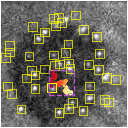

In [4]:
# %% Plot Localizations on cell
f, ax = plt.subplots(1, 1)
f.subplots_adjust(left=0.25, right=0.95, bottom=0.25,
                  top=0.95, wspace=0.5, hspace=0.2)
f.set_figheight(1.8)
f.set_figwidth(1.8)


df_tracksC = df_tracksF.loc[df_tracksF.t == frame]
df_tracksH = df_tracksF.loc[df_tracksF['track.id'] == particleH]
df_tracksHC = df_tracksC.loc[df_tracksC['track.id'] == particleH]

# Plot track of highlighted particle up to the chosen frame x
df_tracksH_worm = df_tracks.loc[(df_tracks['track.id'] == particleH) & (df_tracks.t < frame)]
x = df_tracksH_worm.x
y = df_tracksH_worm.y
cols = np.linspace(0, 1, len(x))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='YlOrRd', alpha=0.8, path_effects=[
                    path_effects.Stroke(capstyle="round")])
lc.set_array(cols)
lc.set_linewidth(1)
ax.add_collection(lc)


# Plot dashed squares to denote localizations
ax.scatter(df_tracksC.x,
           df_tracksC.y,
           marker='s',
           facecolors='none',
           edgecolors='yellow',
           s=40,
           linewidths=0.5,
           alpha=1)

# Plot fatter non-dashed square to denote localization of highlighted particle
ax.scatter(df_tracksHC.x,
           df_tracksHC.y,
           marker='s',
           facecolors='none',
           edgecolors='yellow',
           s=40,
           linewidths=0.75,
           alpha=1,
           zorder=100)

# Create a rectangle patch to mark the highlighted track
track_extent_x = df_tracksH_worm.x.max()-df_tracksH_worm.x.min()
track_extent_y = df_tracksH_worm.y.max()-df_tracksH_worm.y.min()
rect = Rectangle((df_tracksH_worm.x.min(), df_tracksH_worm.y.min()), 1.05*track_extent_x,
                 1.05*track_extent_y, linewidth=1, edgecolor='mediumorchid', facecolor='none', zorder=1000, ls='--')
ax.add_patch(rect)

# Plot background still frame
ax.imshow(movie[frame],
          aspect='auto',
          vmin=130,
          vmax=400,
          cmap=plt.get_cmap('Greys_r'))

ax.invert_yaxis()

square_length = np.max((df_tracks.x.max()-df_tracks.x.min(),
                       df_tracks.y.max()-df_tracks.y.min()))
padding = -1

# add a bit of margin and ensure squaredness of figure
ax.set_xlim([df_tracks.x.min()-padding, padding+df_tracks.x.min()+square_length])
ax.set_ylim([df_tracks.y.min()-padding, padding+df_tracks.y.min()+square_length])
ax.axis('off')
ax.set_aspect('equal')

Text(0.5, 0, 'Time [s]')

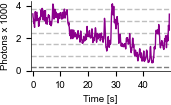

In [8]:
# Plot Intensity vs Time
boxArray, df_particleH = kymo.get_boxes(movie, df_tracks, particleH)
photons, _, _ = kymo.get_intensities(boxArray, df_particleH, smoothing=3)

f, ax = plt.subplots(1, 1)
f.subplots_adjust(left=0.25, right=0.95, bottom=0.25,
                  top=0.95, wspace=0.5, hspace=0.2)
f.set_figheight(1)
f.set_figwidth(2)

# Params
dt = 0.08
alpha = 0.5

# background level
background_nontransfected_cell = 210  # avg of 7x7px square w/o localziation
ax.axhline(background_nontransfected_cell, ls='--', color='black', alpha=alpha)

# photon levels (guides to the eye)
single_photon_intensity = 710  # photon histogram first peak
for i in np.arange(1, 6):
    ax.axhline(i*single_photon_intensity+background_nontransfected_cell,
               ls='--', color='grey', alpha=alpha)

ax.plot(photons, '-', color='darkmagenta', label='Box Mean')

xtick = np.arange(0, photons.shape[0], 10/dt)
ax.set_xticks(xtick)
ax.set_xticklabels((xtick*dt).astype(int))
ax.set_xlim([-10, 625])
ax.set_ylabel('Photons x 1000')
ytick = ax.get_yticks()
ax.set_yticklabels((ytick/1000).astype(int))
ax.set_ylim(bottom=0);
ax.set_xlabel('Time [s]')